<a href="https://colab.research.google.com/github/FelipeGBarreto/Projects/blob/master/Clusters_Acidentes_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLUSTERIZANDO OS ACIDENTES NAS RODOVIAS FEDERAIS DO BRASIL**

# **Método Não Hierárquico**
> Optei pelo um método não hierárquico de análise não supervisionada, devido ao fato de a base de dados ser bem expressiva, o que não performaria bem para um método hierárquico.

**OBJETIVO:** Identificar grupos com características semelhantes com relação a acidentes no Brasil nas rodovias federais, objetivando possíveis políticas de trânsito para atacar e diminuir os acidentes.

## Instalando e carregando os pacotes necessários

In [ ]:
pacotes <- c("tidyverse","cluster","dendextend","factoextra","fpc","gridExtra",
             "readxl","ggplot2","tibble")

if(sum(as.numeric(!pacotes %in% installed.packages())) != 0){
  instalador <- pacotes[!pacotes %in% installed.packages()]
  for(i in 1:length(instalador)) {
    install.packages(instalador, dependencies = T)
    break()}
  sapply(pacotes, require, character = T) 
} else {
  sapply(pacotes, require, character = T) 
}

## Utilizando o método k-means
> Procurando a melhor posição para os centróides dos grupos a serem formados;

> Quanto os clusters não ocorrem naturalmente, o algoritmo tende a dividir a tabela em partes iguais.

In [2]:
acidentes <- read.table("/content/Acidentes nas Rodovias Federais - 2007 a 2020.txt", sep=";", dec=",", header = T)
head(acidentes)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,⋯,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,Ordem_Semana,Ano,Mes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,10.0,2007-11-06,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,⋯,0,4,0,5,0,4,6,1,2007,11
2,10.0,2007-11-06,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,⋯,0,4,0,5,0,4,6,1,2007,11
3,1032898.0,2007-08-13,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,⋯,0,0,1,2,0,1,1,1,2007,8
4,1051130.0,2007-12-02,Segunda,02:10:00,MA,135,11.0,SAO LUIS,Animais na Pista,Atropelamento de animal,⋯,2,2,1,0,0,3,1,1,2007,12
5,1066824.0,2007-11-20,Terça,05:30:00,CE,222,30.8,CAUCAIA,Defeito mecânico em veículo,Capotamento,⋯,0,1,0,0,0,1,1,2,2007,11
6,1069918.0,2007-12-16,Domingo,17:40:00,MA,230,14.0,BARAO DE GRAJAU,Outras,Capotamento,⋯,0,0,1,0,0,1,1,7,2007,12


### Separando as variáveis métricas para verificação dos grupos
> As variáveis categóricas servirão para analisar características dos grupos formados.

In [3]:
acidentes_t <- acidentes[, c("municipio","pessoas","mortos","feridos_leves","feridos_graves","ilesos","ignorados","feridos","veiculos")]

# Somando os valores por município para deixá-los como unique
acidentes_sum <- acidentes_t %>% group_by(municipio) %>% summarise(across(everything(), list(sum)))
acidentes_sum <- acidentes_sum %>% column_to_rownames("municipio")

In [4]:
# Não necessita padronizar essa base em específico, mas farei como rotina
acidentes_sum_pad <- scale(acidentes_sum)

# Substituindo os valores NA por 0, que é a média padronizada da distribuição padrão, para que a análise não saia enviesada
acidentes_sum_pad <- replace(x = acidentes_sum_pad, list = is.na(acidentes_sum_pad), values = 0) 

### Rodando de 4 a 7 centros para visualizar qual a melhor divisão a ser feita

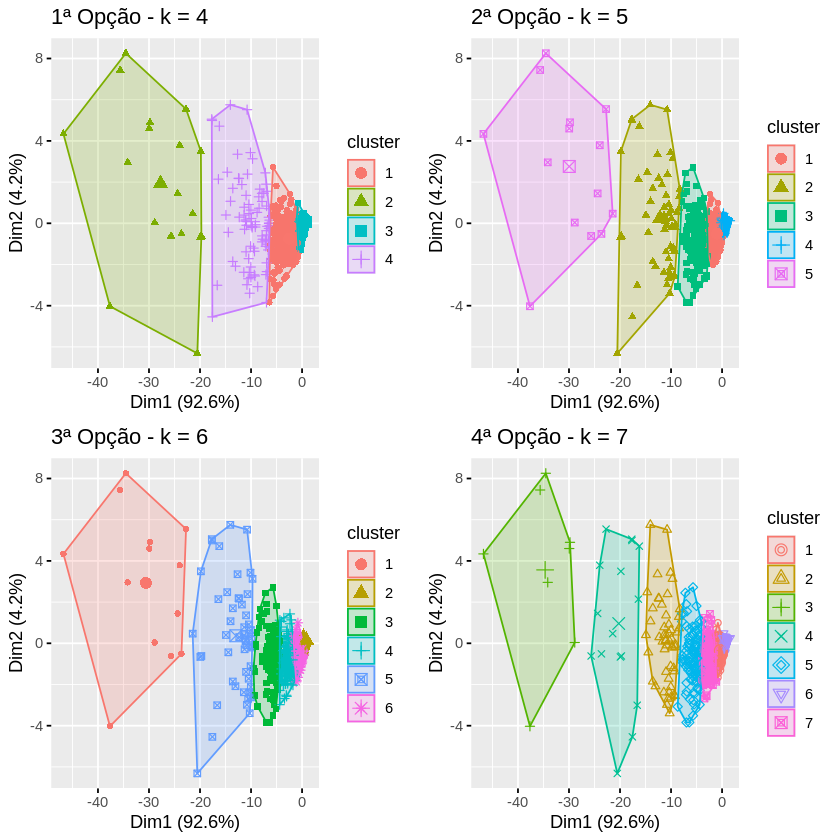

In [5]:
# Criando duas listas para armazenar as opções de clusters e de plots deles
opc_cluster <- list()
graph <- list()

for(i in 1:4){
  opc_cluster[[i]] <- kmeans(acidentes_sum_pad, centers = i + 3)
  graph[[i]] <- fviz_cluster(opc_cluster[[i]], geom = "point", data = acidentes_sum_pad) + ggtitle(paste(i, "ª Opção - k = ",i+3, sep=""))
}

# Plotando as possibilidades predefinidas
grid.arrange(graph[[1]], graph[[2]], graph[[3]], graph[[4]], nrow = 2)

# Outra forma mais manual para fazer
# municip.k4 <- kmeans(acidentes_sum_pad, centers = 4) # Já não tem na, mas se tivesse eu poderia utilizar na.omit(dataset)
# G1 <- fviz_cluster(municip.k4, geom = "point", data = acidentes_sum_pad) + ggtitle("k = 4")
# grid.arrange(G1, G2, G3, G4, nrow = 2)

### Verificando possíveis quantidades de clusters com o método Elbow

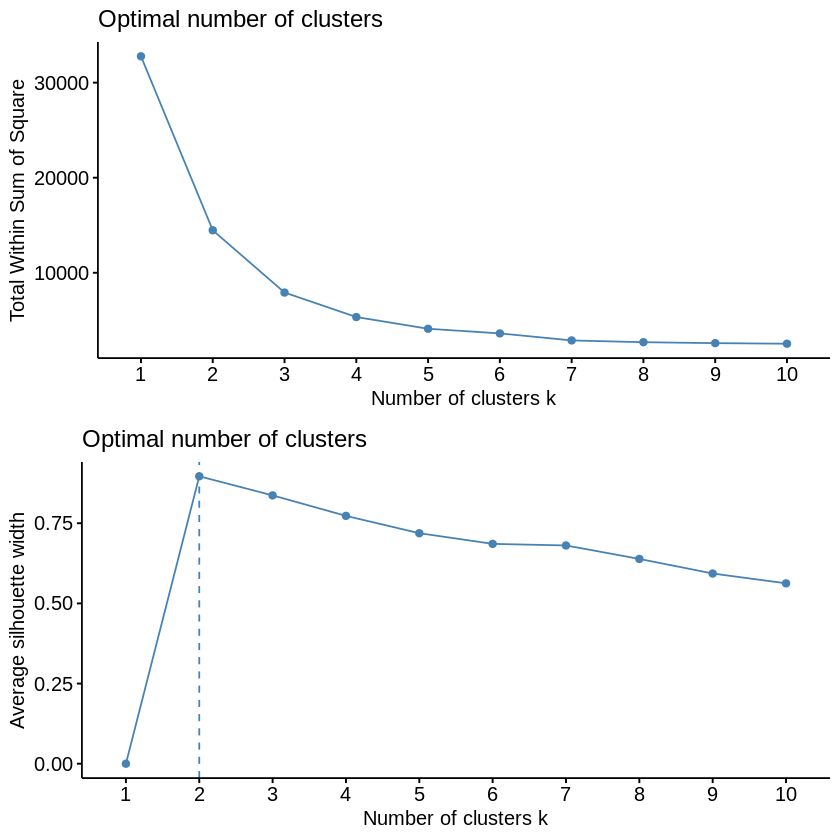

In [6]:
grid.arrange(
  fviz_nbclust(acidentes_sum_pad, kmeans, method = "wss"), # Método Elbow (cotovelo)
  fviz_nbclust(acidentes_sum_pad, kmeans, method = "silhouette") # Método da Silhouette
  )

- Analisando a variabilidade, escolhi 7 grupos para trabalhar

In [7]:
# Armazenando a 4ª opção escolhida (7 clusters)
municip.k7 <- opc_cluster[[4]]

### Juntando os dados

In [8]:
acidentes_clusters <- cbind(acidentes_sum, data.frame(municip.k7$cluster))
acidentes_clusters[sample(nrow(acidentes_clusters),5), ]

,pessoas_1,mortos_1,feridos_leves_1,feridos_graves_1,ilesos_1,ignorados_1,feridos_1,veiculos_1,municip.k7.cluster
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
MARQUES DE SOUZA,129,3,34,11,79,2,45,55,6
BRAGANCA,349,26,91,61,143,28,152,269,6
APIUNA,4217,95,1027,332,2613,150,1359,3589,7
QUARAI,162,10,49,27,73,3,76,99,6
JACARAU,4,0,3,0,1,0,3,1,6


### Média dos clusters criados

In [9]:
# Médias por grupo
acidentes_clusters %>% group_by("Grupos" = municip.k7.cluster) %>% summarise("Quantidade"=n() ,across(everything(), list(mean)))

Grupos,Quantidade,pessoas_1_1,mortos_1_1,feridos_leves_1_1,feridos_graves_1_1,ilesos_1_1,ignorados_1_1,feridos_1_1,veiculos_1_1,municip.k7.cluster_1,Quantidade_1
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,615,1175.8081,44.673171,303.44065,117.89593,662.67317,47.112195,421.33659,850.36748,1,615
2,50,13529.3200,188.420000,2710.64000,846.50000,9212.38000,571.000000,3557.14000,11540.00000,2,50
3,8,41212.2500,433.250000,8394.12500,2202.00000,28083.25000,2098.000000,10596.12500,35403.25000,3,8
4,16,23841.1250,298.625000,4339.31250,1628.93750,16376.62500,1196.875000,5968.25000,20947.18750,4,16
5,111,6839.6396,136.108108,1569.89189,513.91892,4333.79279,285.774775,2083.81081,5491.66667,5,111
6,3042,121.2531,5.228139,35.37936,12.68212,62.34911,5.613741,48.06147,84.15976,6,3042
7,255,3169.8667,89.670588,775.04314,291.70588,1893.17647,120.176471,1066.74902,2409.47451,7,255


**OBSERVAÇÃO:** Há dois clusters que merecem ser estudados com maiores detalhes, os quais são:
- Grupo 3: esse grupo tem a menor quantidade de cidades, mas a maior quantidade de mortes ao longo do tempo: Representa a maior quantodade de municípios, porém com a menor média de mortes de no período em estudo;

- Grupo 6: comportamento oposto ao grupo 3.

### Análise do menor cluster

In [10]:
cluster_3 <- acidentes_clusters[acidentes_clusters$municip.k7.cluster == 3, ] %>% rownames_to_column("Municipios")
cluster_3_municipios <- acidentes[(acidentes$municipio %in% cluster_3$Municipios), ]

In [11]:
write_csv2(cluster_3_municipios, "Acidentes_cluster_3.csv")

In [12]:
# grupo <- acidentes_clusters %>% rownames_to_column("Municipios") %>% select(Municipios, "Gurpo" = municip.k7.cluster)
# grupo[grupo$Municipios == "SAO PAULO", ]